# Introduction to Iterative Reconstruction in PET
*   Create a realistic FDG brain PET phantom, $f(x)$
*   Create a measured sinogram $\mathbf{m}$ with optional Poisson noise
*   Reconstruct an image $\mathbf{x}$ using ML-EM
*   Assess image quality as a function of iteration $k$
*   Build in resolution modelling (PSF) to recover resolution and improve image quality
*   Compare reconstructions, with and without PSF, compared to FBP
* Fast introduction to PET acquisition & reconstruction (https://youtube.com/shorts/6qYFdcUFqig)
* Video examples: https://www.youtube.com/@AndrewJReader for playlists
* All code by A. J. Reader (andrew.reader@kcl.ac.uk)




In [1]:
# ----------------------------- IMPORT LIBRARIES AND SET DEFAULTS ---------------------------
import numpy as np, matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm                               # For progress tracking in loops
from skimage.transform import radon, iradon         # Radon and inverse Radon transform functions
from scipy.ndimage     import gaussian_filter as smooth
from IPython.display   import display, clear_output # For animated updates

plt.rcParams.update({'image.cmap':'Greys_r', 'figure.figsize': (12,4),'font.size':8,'figure.dpi': 300})

# ------ If faster code is required, reduce the number of pixels below, nxd ------

image_width_mm = 232.0 # Width of reconstructed image in mm
nxd            = 96    # User choice (128 -> dx=1.8125 mm, 256 -> dx=0.90625 mm pixel side length)
dx             = image_width_mm / nxd  # pixel side length in mm (do not change, based on user's nxd)

#   Create a realistic FDG brain PET phantom, $f(x)$


Text(0.5, 1.0, 'True object: BrainWeb PET FDG')

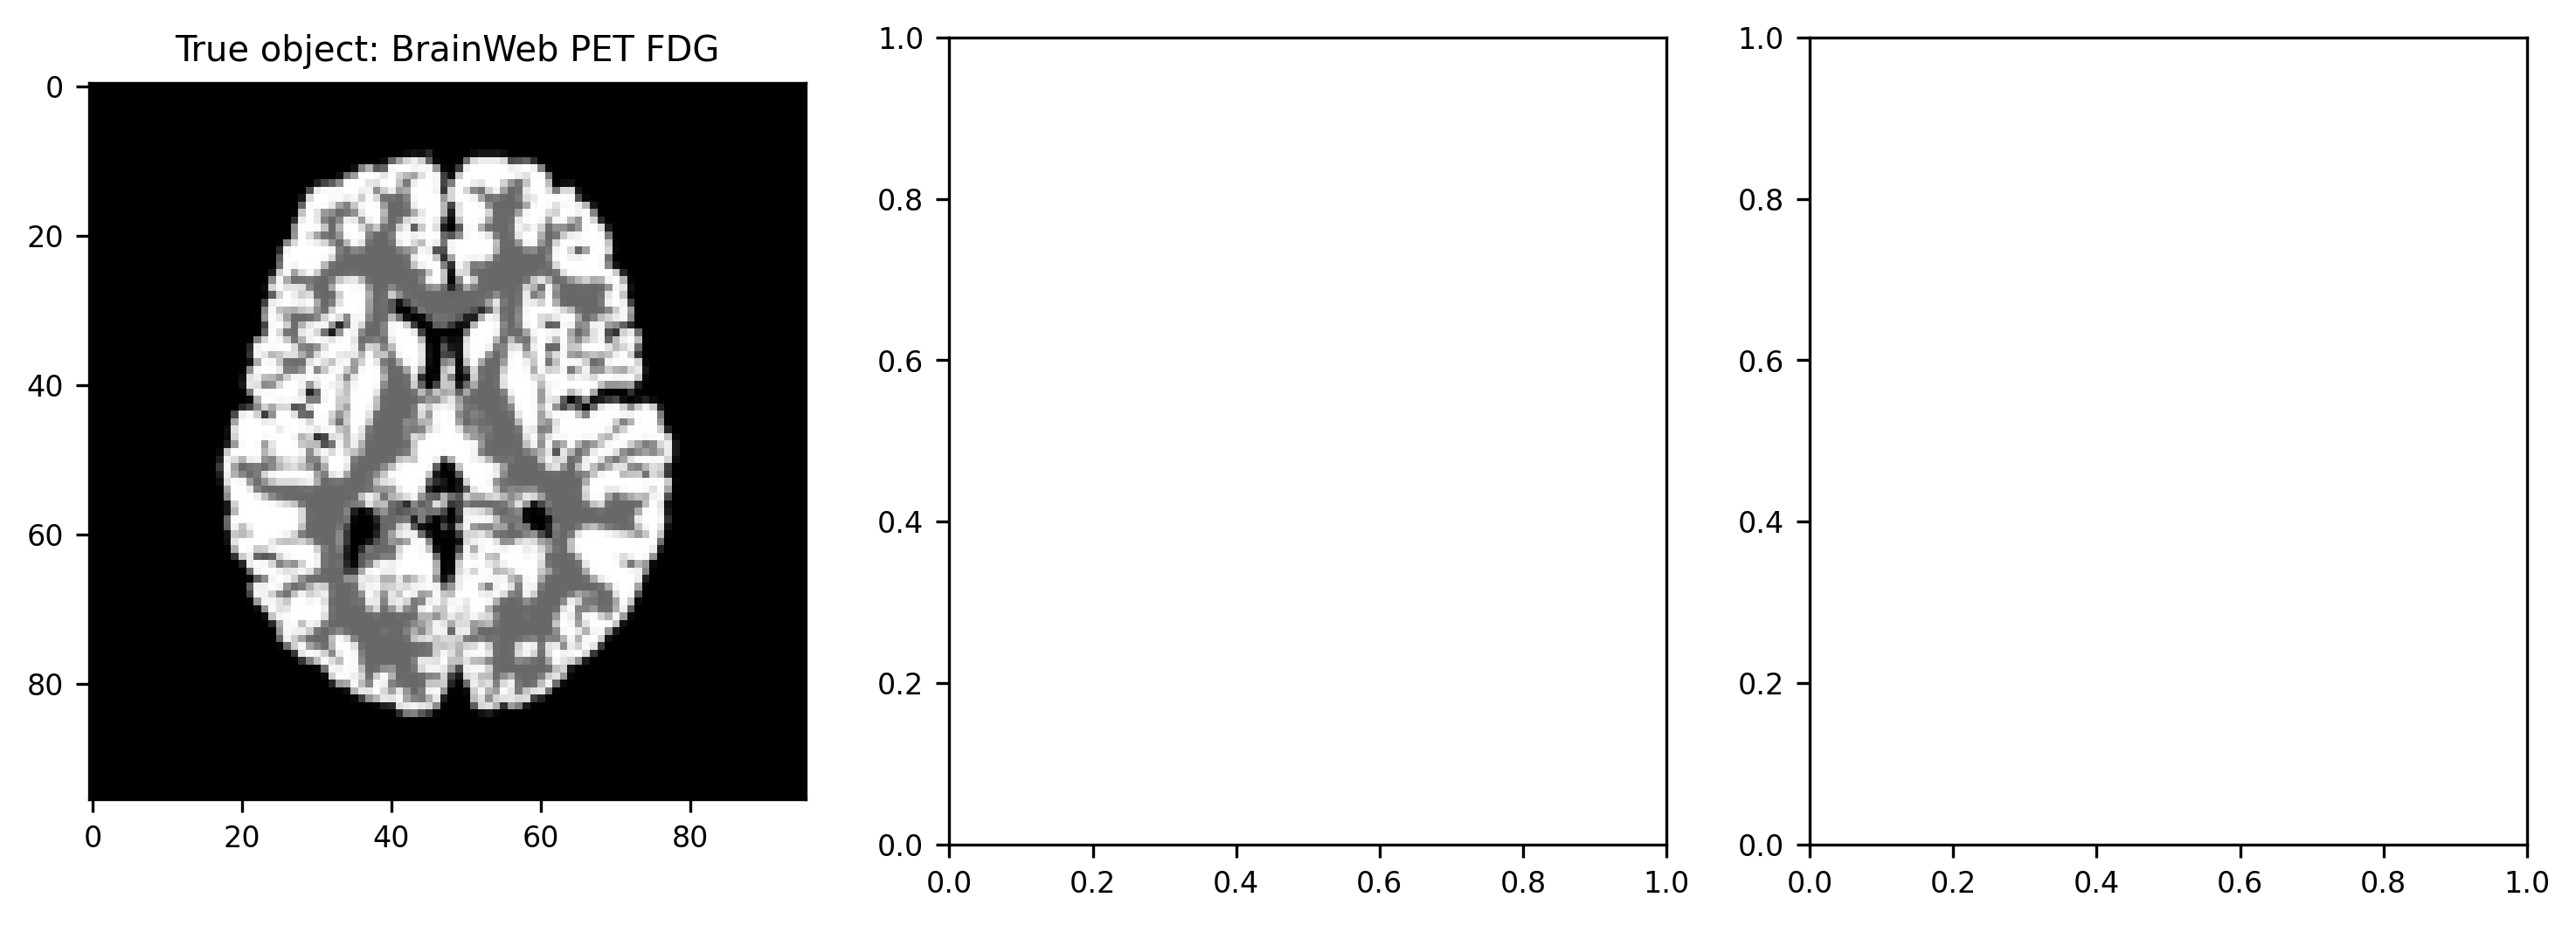

In [2]:
true_name =  'BrainWeb PET FDG'
!pip install brainweb > /dev/null 2>&1
import brainweb as bw # Make *** PET FDG *** from 3D tissue map (subject choices 0...19)

# Read one of the subjects, here we choose the first one [0]
subject_of_interest = list(bw.LINKS.keys())[0]
f_path = bw.get_file(subject_of_interest, bw.LINKS[subject_of_interest])
tissue = np.pad(bw.load_file(f_path), ((0,0), (12,12), (48,48))).astype('f4')

pet = np.zeros_like(tissue)
pet[(tissue == 48)] = 32 # White matter
pet[(tissue == 32)] = 96 # Grey matter
true = np.flipud(resize(pet[160,:,:], (nxd,nxd))) # Slice 160 (can use 20...300)

true *= 1.0/np.max(true) # Standardise maximum value, will adjust later
fig, axs = plt.subplots(1,3) # DISPLAY THE TRUE OBJECT
axs[0].imshow(true); axs[0].set_title("True object: %s" % true_name)

# Optional extra task: display 2 more different slices of the FDG brain phantom

Text(0.5, 1.0, 'Noisy sinogram')

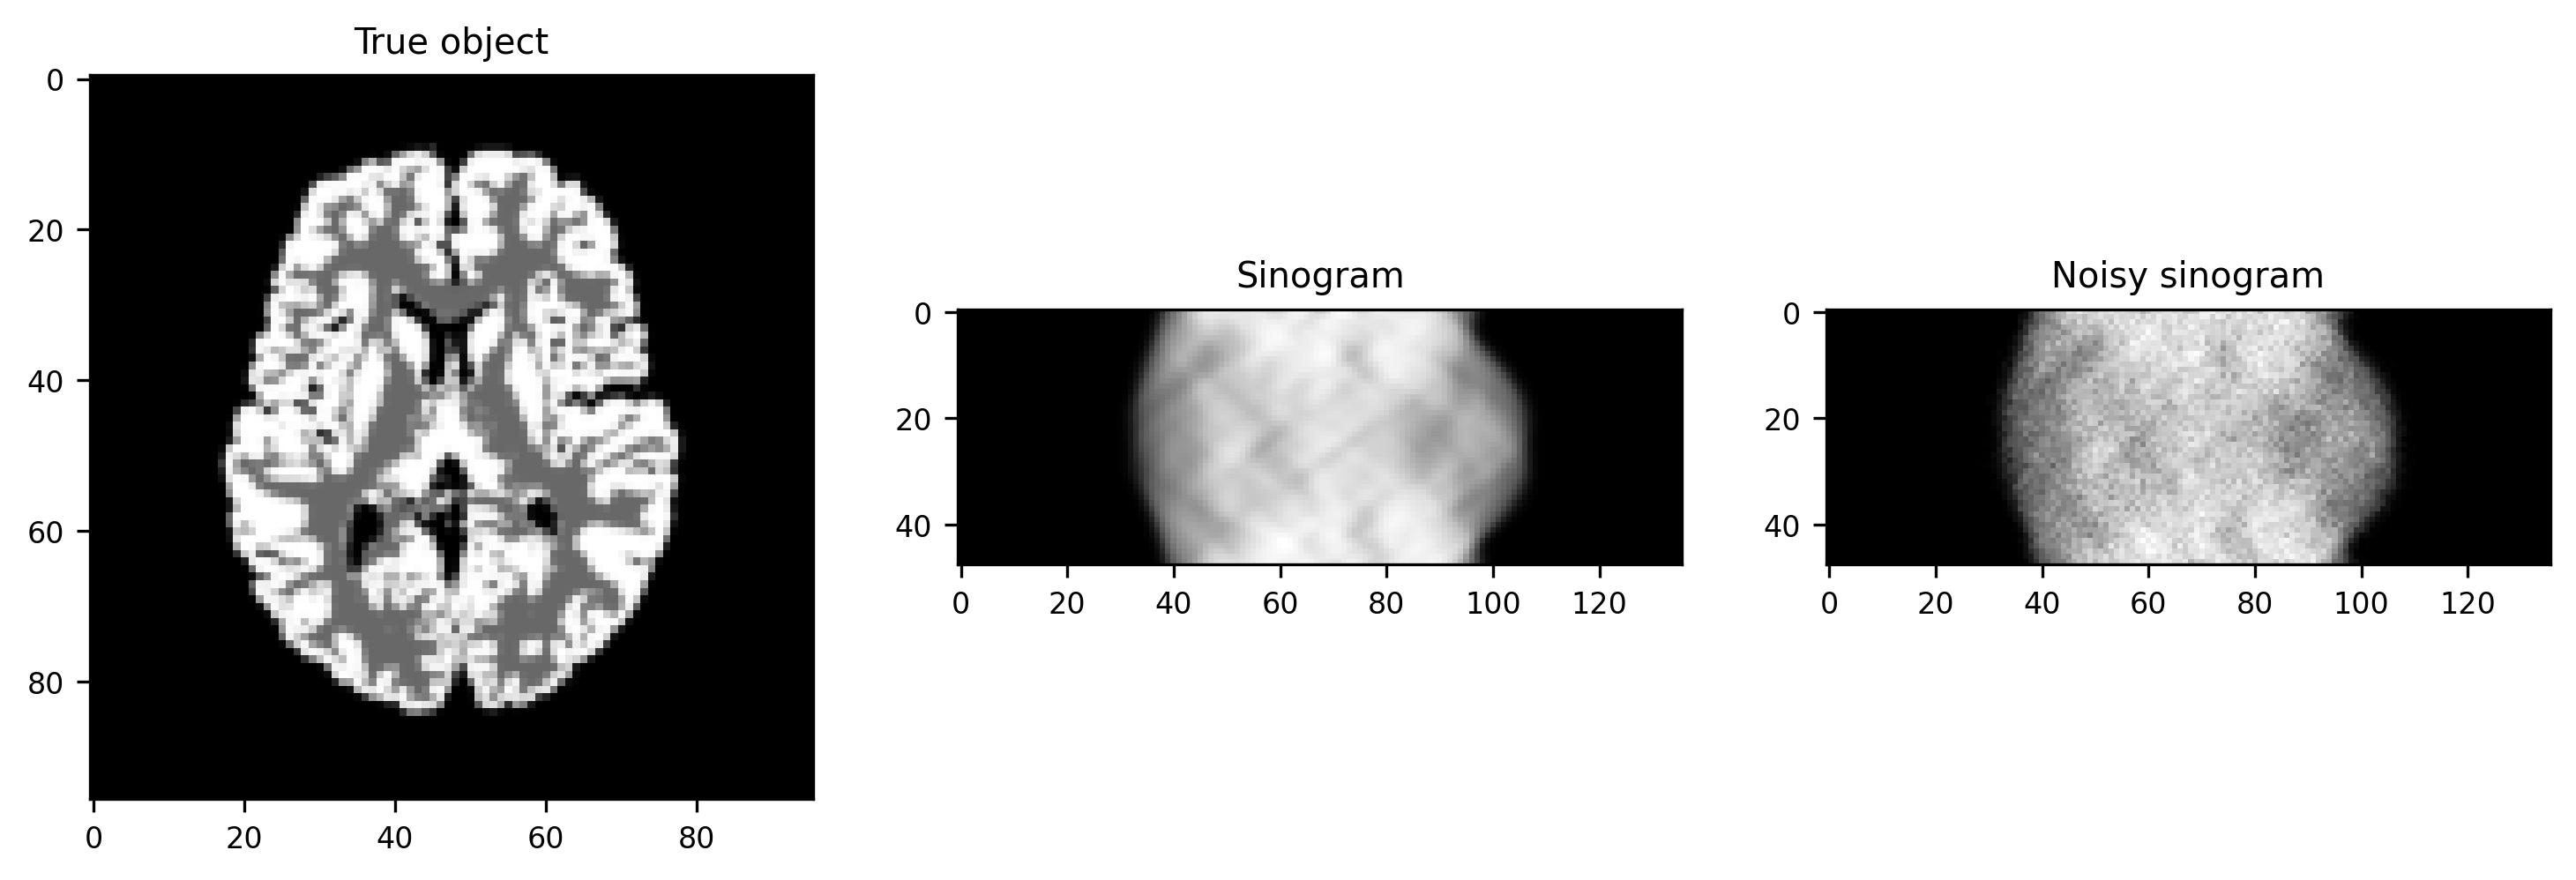

In [3]:
# -------------------------------------------------------------------------------------------
# ------------------- GENERATE SINOGRAM DATA READY FOR RECONSTRUCTION -----------------------
# --- IMPORTANT CONSTANTS: total_activity (noise level). nphid (scanner angular sampling) ---
# -------------------------------------------------------------------------------------------
fig, axs = plt.subplots(1,3)

# Smaller total -> less radioactivity -> noisier data. NB: higher nxd -> noisier data.
total_activity = 10000.0
true *= total_activity/np.sum(true) # Make sum of true match the total radioactivity level

# A small number of angles, 48, has been chosen for speed
nphid = 48 # Fixed number of scanner angles (independent of nxd, and pixel size dx)
azi_angles = np.linspace(0.0,180.0, nphid, endpoint=False) # Azimuthal projection angles, phi

# Do the Radon transform: forward project along parallel lines for the viewing angles
# Blur true (σ = 2.0 mm) before projection, & blur sinogram (σ = 2.0 mm) after projection
# to model limited resolution & avoid unrealistic perfect matches between data and models
acq_sigma = 2.0 # acqusition blurring level
sinogram = smooth(radon(smooth(true, acq_sigma/dx), azi_angles, False), acq_sigma/dx)
nrd = sinogram.shape[0]

noisy_sinogram = np.random.poisson(sinogram)

axs[0].imshow(true);             axs[0].set_title("True object")
axs[1].imshow(sinogram.T);       axs[1].set_title("Sinogram")
axs[2].imshow(noisy_sinogram.T); axs[2].set_title("Noisy sinogram")

# Optional extra tasks to consider: using iradon, for noise-free and noisy sinogram data
# 1) show a plain (unfiltered) backprojected image
# 2) show a filtered backprojection (FBP) reconstruction

In [4]:
# -------------------------------------------------------------------------------------------
# -------------------- ANIMATED VERSION OF MLEM WITH DISPLAY UPDATES ------------------------
# -------------------------------------------------------------------------------------------
def mlem_radon_ANIMATE(sinogram, list_of_iteration_nums): # Global: azi_angles

    bp_1 = iradon(np.ones_like(sinogram),azi_angles,filter_name=None,circle=False)
    x    = np.ones_like(bp_1); history = []

    fig,axs = plt.subplots(2,3)

    for it in range(np.max(list_of_iteration_nums)):
        fp_recon = radon(x, azi_angles,  circle=False)
        ratio    = sinogram / (fp_recon + 1e-8)
        bp_ratio = iradon(ratio, azi_angles, filter_name=None, circle=False)
        x        = x * bp_ratio / (bp_1 + 1e-8)
        history.append(x.copy())  # Store the current iterate

        # VISUALISE and ANIMATE
        for a in axs.flat:
            a.cla();  a.axis('off'); # Clear the images, and remove tick marks
        for ax, ima, title in [
                (axs[0,0], true,         'True'),
                (axs[0,1], sinogram.T,   'Sinogram'),
                (axs[0,2], ratio.T,      'Sino / Pred'),
                (axs[1,1], fp_recon.T,   'FP(Recon)'),
                (axs[1,2], bp_ratio,     'BP(Sino / Pred)'),
                (axs[1,0], history[it], f'Recon iteration {it}') ]:
            ax.imshow(ima); ax.set_title(title)

        clear_output(wait = True); display(fig); plt.pause(0.1)

    return x, history

In [5]:
# -------------------------------------------------------------------------------------------
# ------------------------------------- MLEM+PSF --------------------------------------------
# -------------------------------------------------------------------------------------------
def mlem_radon_imagePSF(sinogram, list_of_iteration_nums): # Global: azi_angles
    sig = 2.7/dx # Image space Gaussian kernel sigma 2.0mm, calculated in pixels

    bp_1 = smooth(iradon(np.ones_like(sinogram),azi_angles,filter_name=None,circle=False),sig)
    x    = np.ones_like(bp_1); history = []
    for it in range(np.max(list_of_iteration_nums)):
        fp_recon = radon(smooth(x,sig), azi_angles,  circle=False)
        ratio    = sinogram / (fp_recon + 1e-8)
        bp_ratio = smooth(iradon(ratio, azi_angles, filter_name=None, circle=False),sig)
        x        = x * bp_ratio / (bp_1 + 1e-8)
        history.append(x.copy())  # Store the current iterate
    return x, history

# Run the two reconstruction methods (MLEM, and MLEM+PSF)
* The first reconstruction will be run with visible updates in the display below the code, for every iteration
* The second reconstruction will be run without visualising the updates (faster to run)

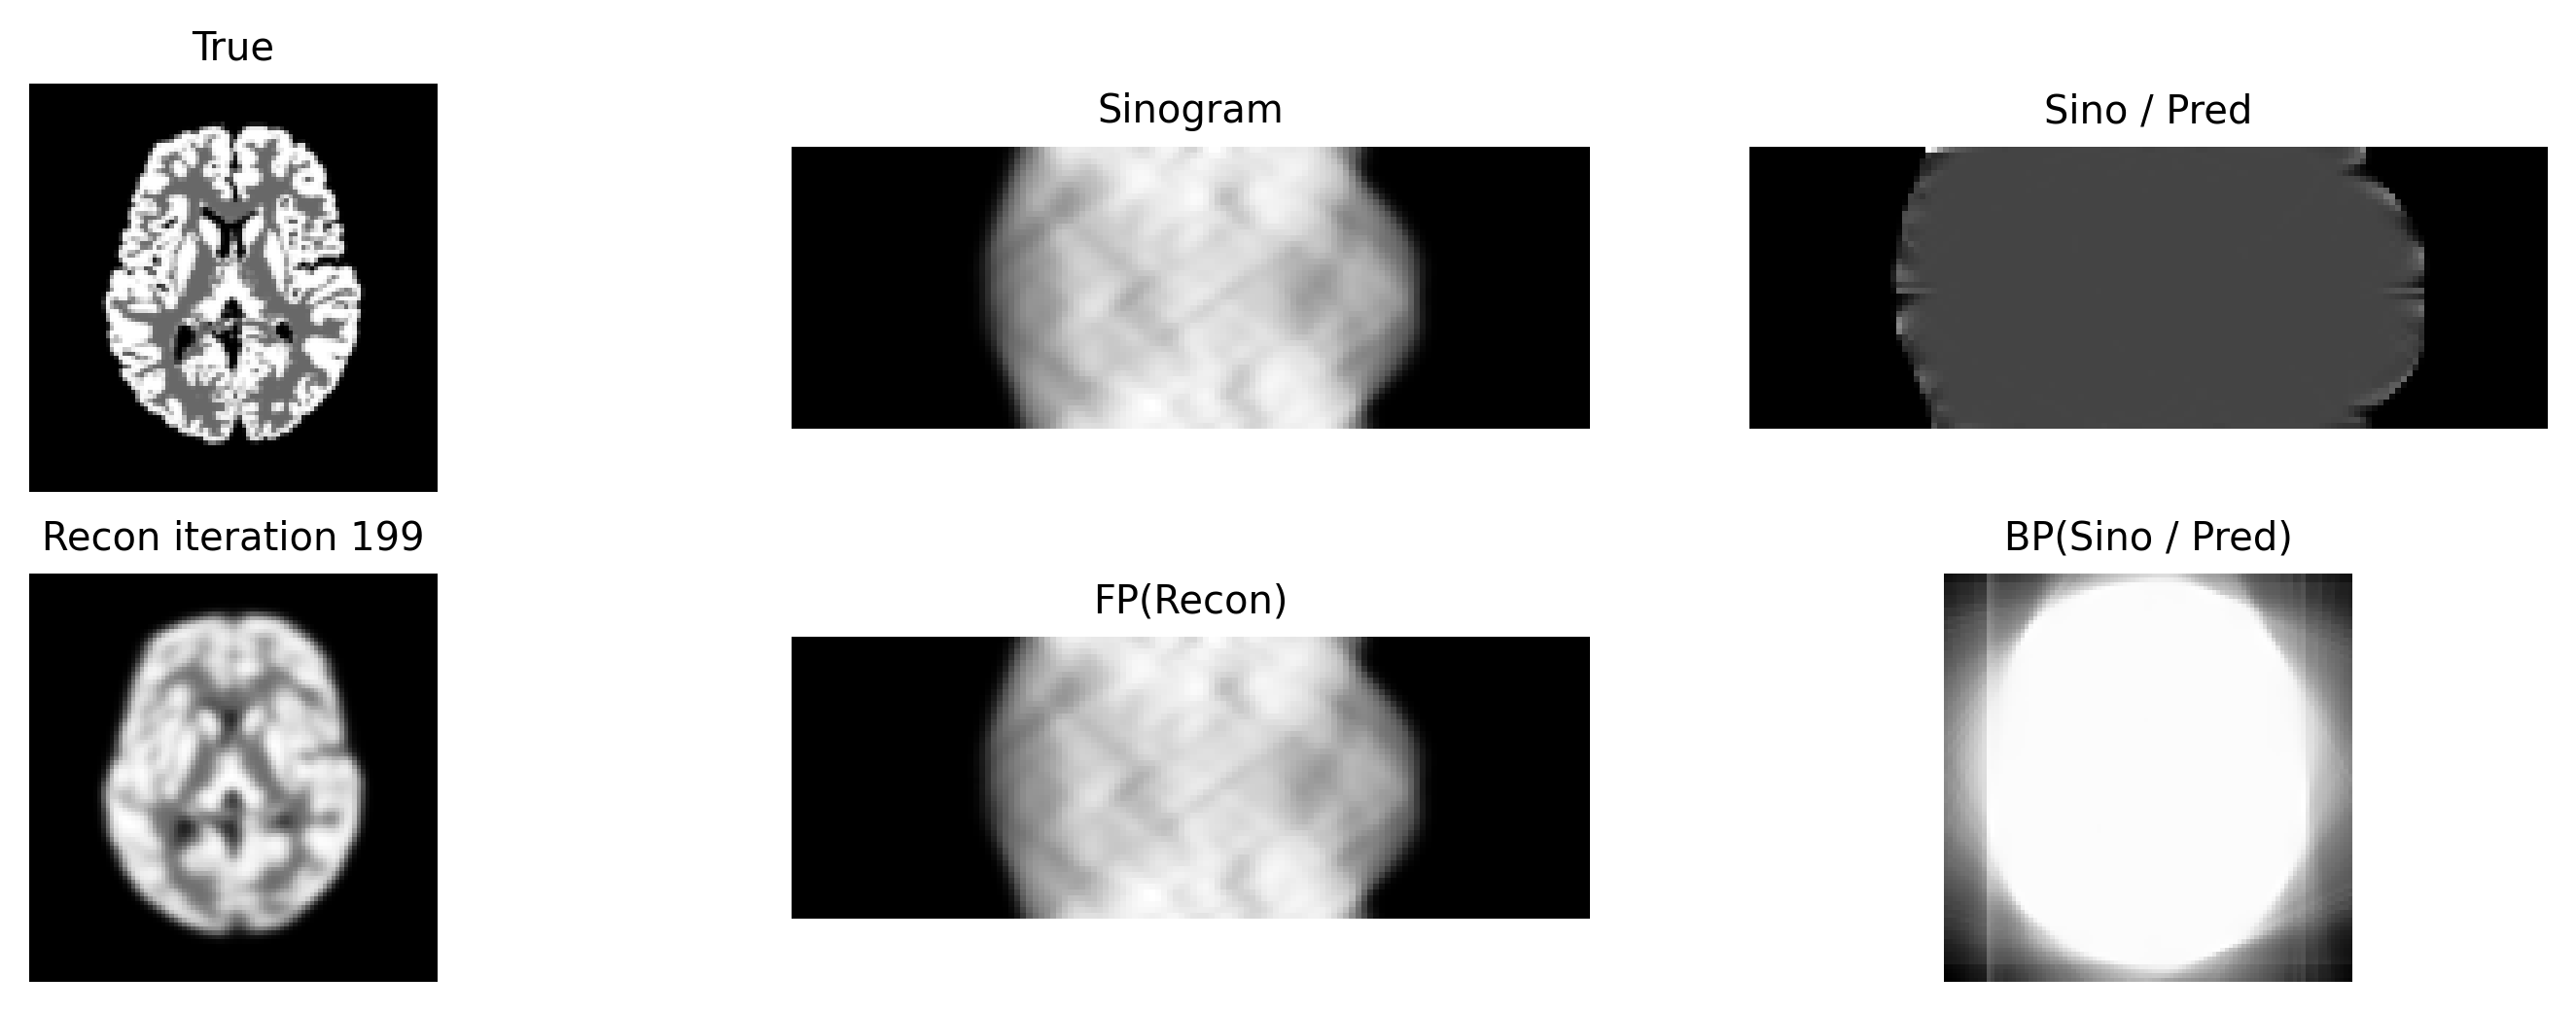

In [6]:
# Now do reconstructions (MLEM, with animation, then MLEM+PSF without animation)
rec, rec_iterations        = mlem_radon_ANIMATE(sinogram, 200)
recPSF, recPSF_iterations  = mlem_radon_imagePSF(sinogram, 200)

# Image quality evaluation
* Use a basic image quality metric to compare performance of the different image reconstruction methods

Text(0.5, 1.0, 'TRUE')

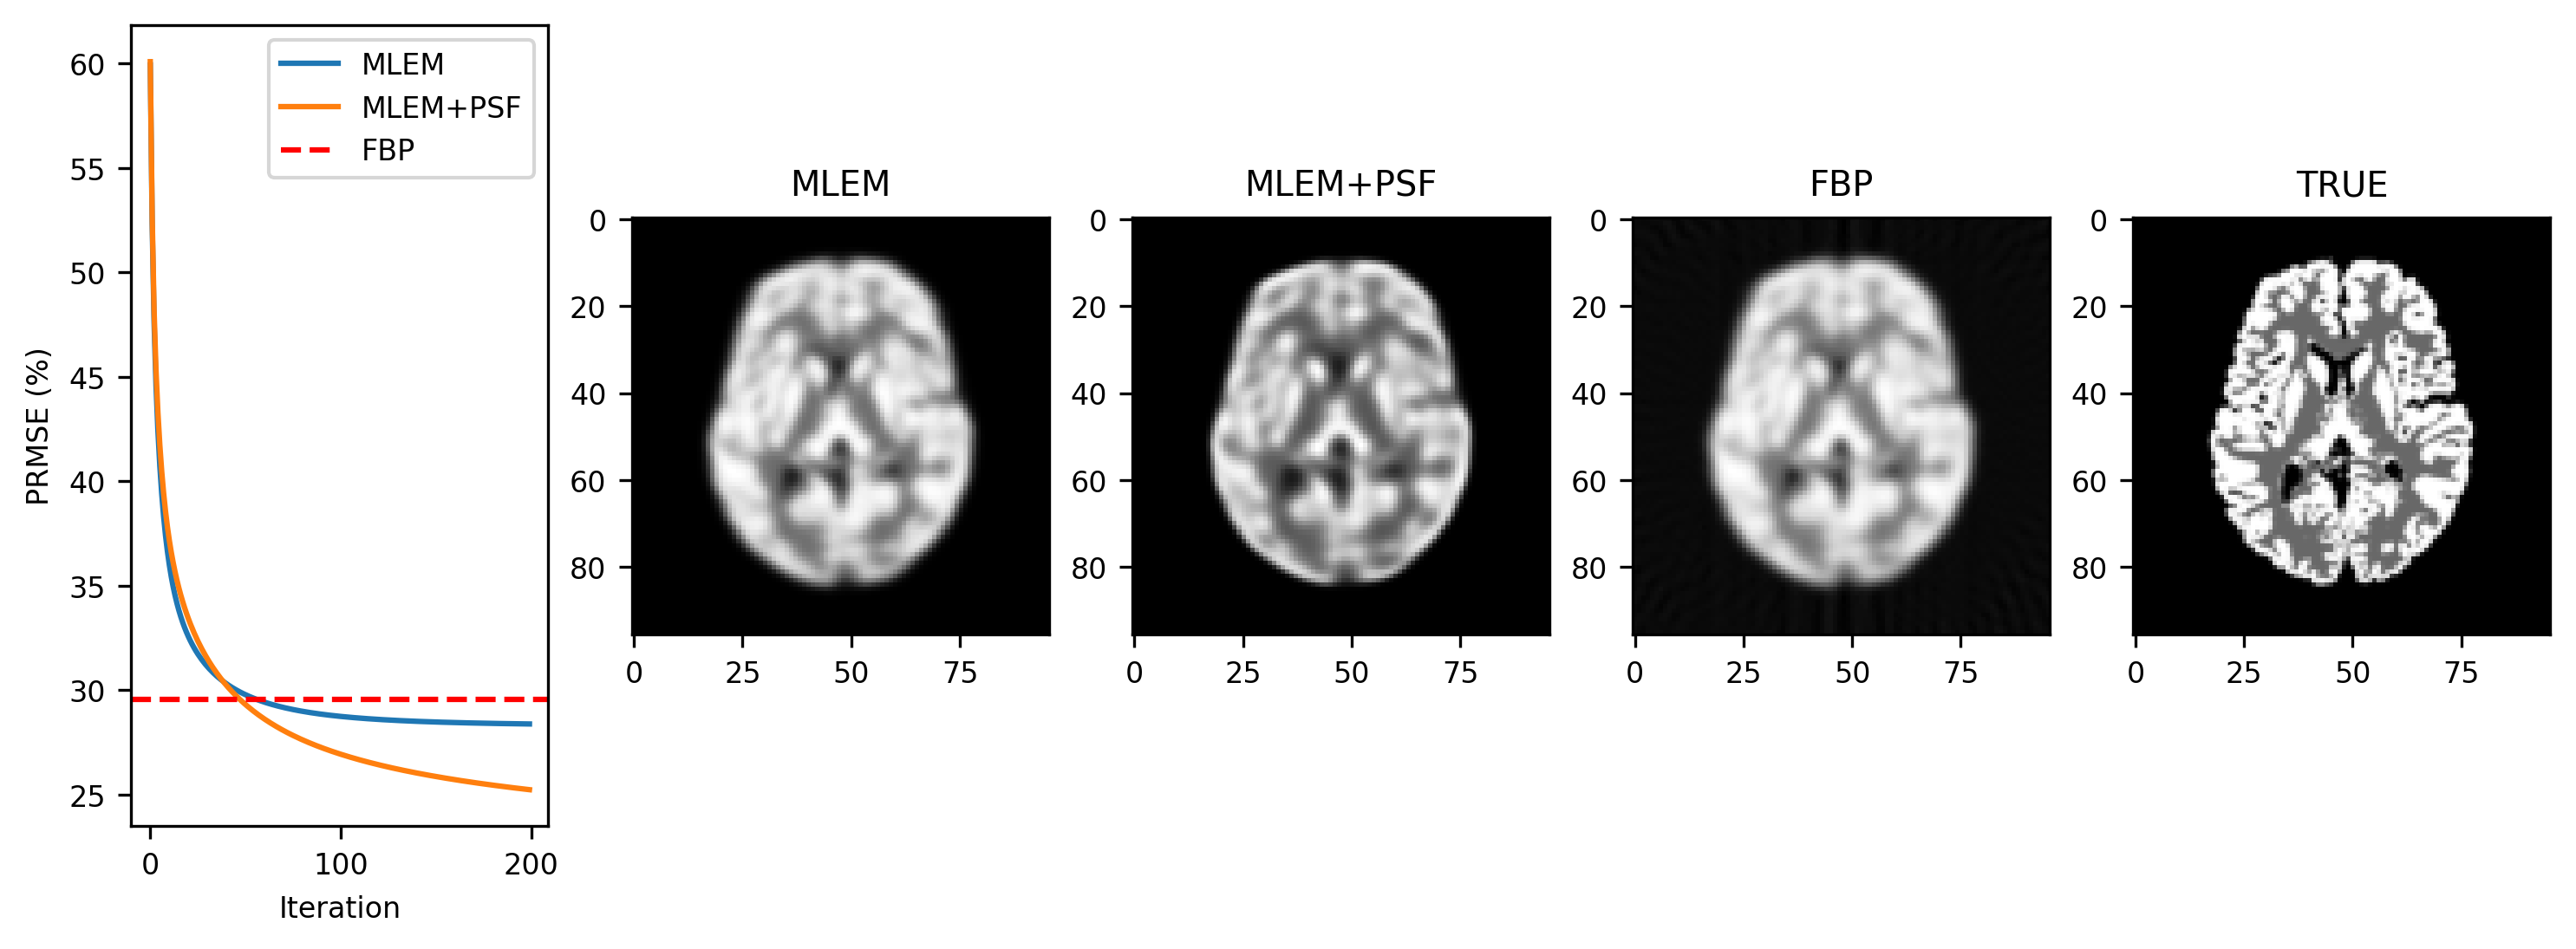

In [7]:
# -------------------------------------------------------------------------------------------
# PERCENTAGE ROOT MEAN SQUARE ERROR FUNCTION FOR IMAGE QUALITY ASSESSMENT
# -------------------------------------------------------------------------------------------
def prmse(im, ref):  # % root mean square error
    mask  = ref > 0.0  # defines pixels to be used
    diff2 = (im[mask] - ref[mask])**2
    ref2  = (           ref[mask])**2
    return 100.0 * (np.sqrt( np.sum(diff2) / np.sum(ref2) ))

# FBP reconstruction
fbp_recon = iradon(sinogram, azi_angles, circle=False)

fig, axs = plt.subplots(1,5)
prmse_array1 = [prmse(img, true) for img in rec_iterations]
prmse_array2 = [prmse(img, true) for img in recPSF_iterations]
prmse_fbp    = prmse(fbp_recon, true)

axs[0].plot(prmse_array1, label='MLEM')
axs[0].plot(prmse_array2, label='MLEM+PSF')
axs[0].axhline(y=prmse_fbp, linestyle='--', color='red', label='FBP')

axs[0].set_xlabel('Iteration');       axs[0].set_ylabel('PRMSE (%)')
axs[0].legend()

axs[1].imshow(rec_iterations[-1]);    axs[1].set_title("MLEM")
axs[2].imshow(recPSF_iterations[-1]); axs[2].set_title("MLEM+PSF")
axs[3].imshow(fbp_recon);             axs[3].set_title("FBP")
axs[4].imshow(true);                  axs[4].set_title("TRUE")

# Optional extra tasks to consider:
# 1) For both noise-free and noisy data, show the PRMSE
# 2) Show profiles through all the reconstructed images, compared to the true

# Introduction to AI

* As an introduction, we will look at image to image mappings first, before reconstruction
* Instead of NumPy arrays, we need to use PyTorch tensors - consider these like any other array, except that crucially they allow tracking of gradients, which is essential in order to optimise (i.e. train) parameters
* **To speed up processing it is best to use a GPU. For colab, go to Runtime, then Change runtime type, and select a GPU from the options**
*  Start by defining a NxN convolution kernel to sharpen, denoise or transform an image
*  Set up a training loop for the kernel, to update its parameters according to a target output and loss function
*  Upgrade performance via a convolutional neural network (CNN)


cuda:0


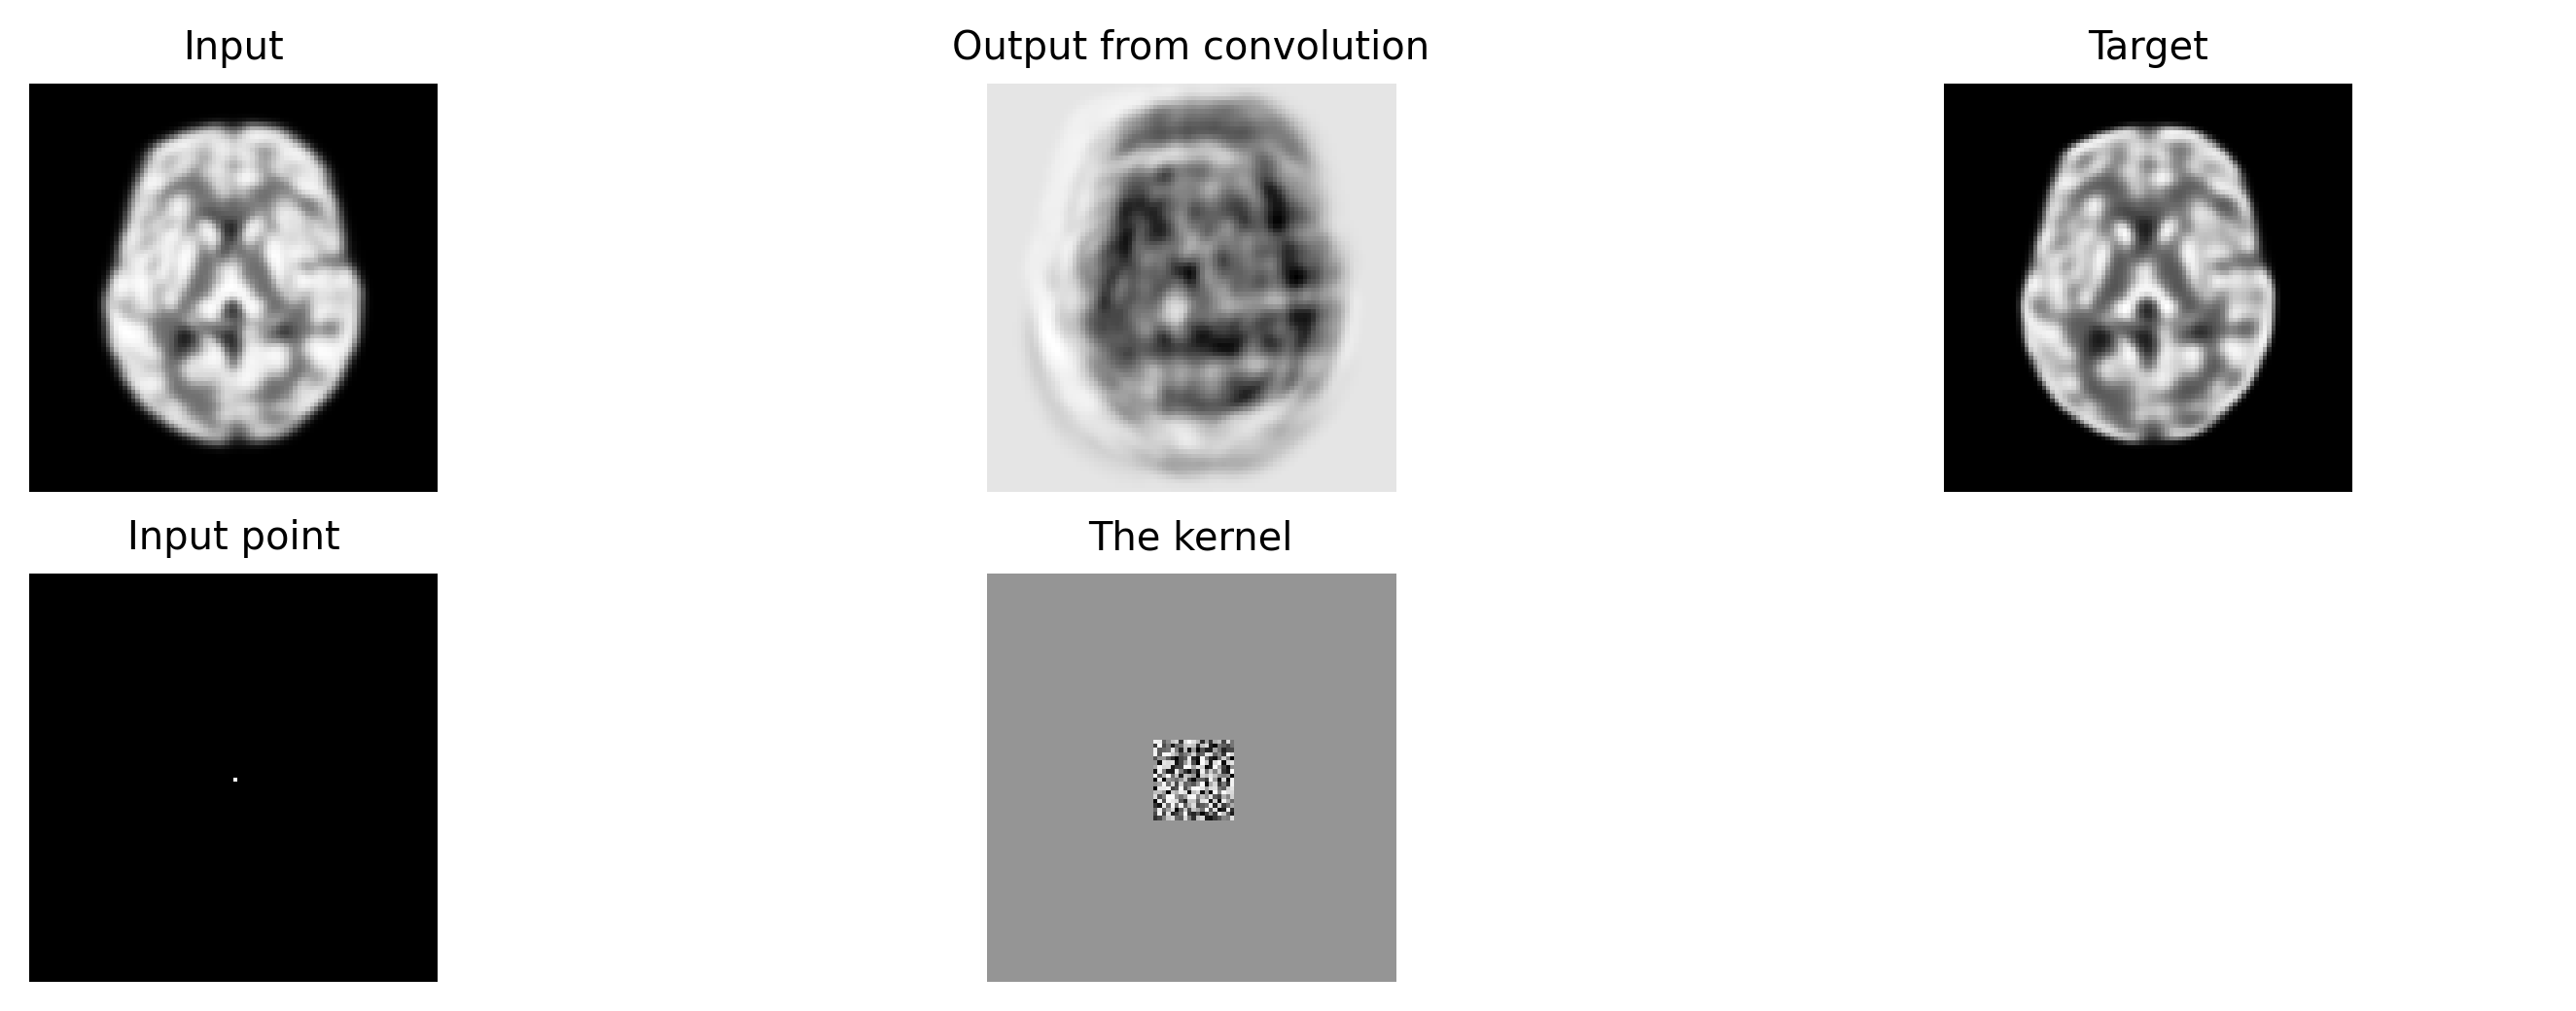

In [8]:
import torch as th, torch.nn as nn

# -------------------------TORCH TO NUMPY CONVERTORS-----------------------------------------
def th_2_np(th_array):   return np.squeeze(th_array.detach().cpu().numpy())
def np_2_th(np_array):   return th.from_numpy(np_array).float()

# ------------------------ USE GPU IF AVAILABLE ---------------------------------------------
device = th.device("cuda:0" if th.cuda.is_available() else "cpu"); print(device)

# -------------------------------------------------------------------------------------------
# ----------------- SET UP A CLASS FOR A TRAINABLE CONVOLUTION KERNEL -----------------------
# -------------------------------------------------------------------------------------------
class Convolution_NxN(nn.Module):
    def __init__(self, kernel_size=11):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size, padding = kernel_size//2)

    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0) # x is a 2D image: unsqueeze for (N,C,H,W) format
        x = self.conv(x)                # Perform convolution
        return x.squeeze(0).squeeze(0)  # Squeeze back to a 2D image, (H,W) format

# -------------------------------------------------------------------------------------------
# ---------------------- CREATE AN OBJECT THAT PERFORMS THE CONVOLUTION ---------------------
# -------------------------------------------------------------------------------------------
kernel_size       = 19
trainable_kernel  = Convolution_NxN(kernel_size).to(device) # Create trainable kernel object
model_name        = 'One %dx%d kernel' % (kernel_size,kernel_size)

input_image_th  = np_2_th(rec_iterations[-1]).to(device)
target_image_th = np_2_th(recPSF_iterations[-1]).to(device)
point_input_th  = th.zeros_like(input_image_th).to(device)
point_input_th[nxd//2,nxd//2] = 1.0 # Point source in the middle of the image

# First try out the kernel without any training
output_image_th = trainable_kernel(input_image_th)
output_kern_th  = trainable_kernel(point_input_th) # Get the kernel

fig, axs = plt.subplots(2,3)
for ax in axs.flat: ax.axis('off')

for ax, ima, title in [
        (axs[0,0], input_image_th,  'Input'),
        (axs[0,1], output_image_th, 'Output from convolution'),
        (axs[0,2], target_image_th, 'Target'),
        (axs[1,0], point_input_th,  'Input point'),
        (axs[1,1], output_kern_th,  'The kernel') ]:
    ax.imshow(th_2_np(ima)); ax.set_title(title)

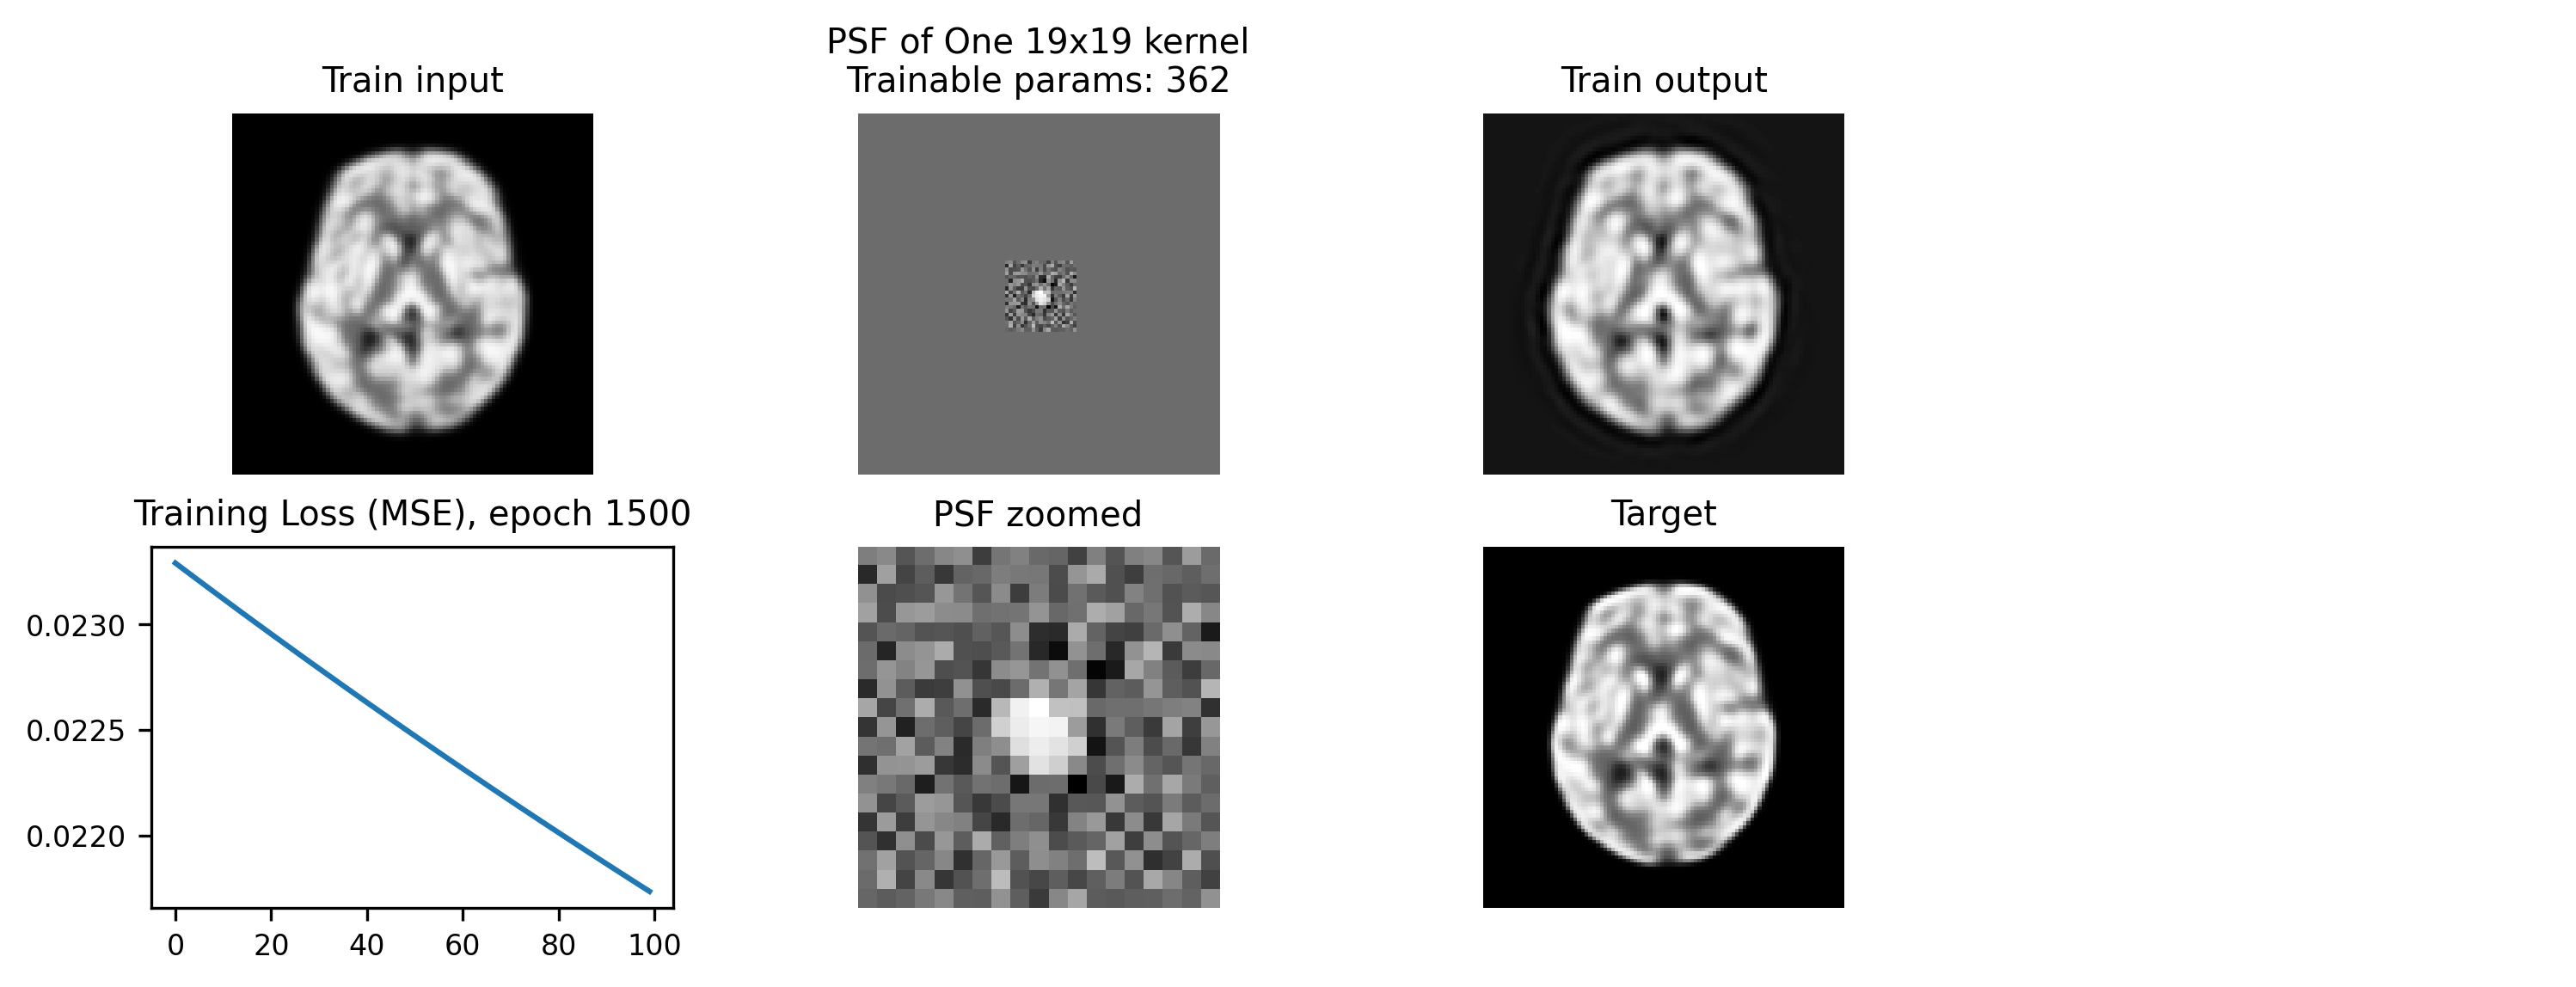

In [9]:
# -------------------------------------------------------------------------------------------
# ----------------- SET UP LOSS FUNCTION, OPTIMISER, AND LIST TO RECORD LOSS ----------------
# -------------------------------------------------------------------------------------------
loss_function = nn.MSELoss()
optimiser     = th.optim.Adam(trainable_kernel.parameters(), lr=1e-3)
train_loss    = list() # Track the value of the loss function while training the kernel

# Function to count the number of trainable parameters in a model
def count_parameters(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)

# -------------------------------------------------------------------------------------------
# ---------------------------- TRAIN THE CONVOLUTION KERNEL ---------------------------------
# -------------------------------------------------------------------------------------------
total_epochs     = 1500
fig, axs = plt.subplots(2,4)

for ep in range(total_epochs+1):
    trainable_kernel.train()  # Ensure the model is in training mode
    optimiser.zero_grad()     # set the gradients to zero

    # Pass the input image through the model, and evaluate the loss
    training_output_th = trainable_kernel(input_image_th)
    loss = loss_function(training_output_th, target_image_th)
    train_loss.append(loss.item())

    output_kern_th = trainable_kernel(point_input_th)
    loss.backward()    # Find the gradients
    optimiser.step()   # Does the update

    if ep % 50 == 0:
        for a in axs.flat:
            a.cla(); a.axis('off')

        axs[1,0].axis('on')
        axs[1,0].plot(train_loss[-100:]); axs[1,0].set_title(f'Training Loss (MSE), epoch {ep}')

        axs[0,0].imshow(th_2_np(input_image_th),vmax=np.max(true));     axs[0,0].set_title('Train input')
        axs[0,2].imshow(th_2_np(training_output_th),vmax=np.max(true)); axs[0,2].set_title('Train output')
        axs[1,2].imshow(th_2_np(target_image_th),vmax=np.max(true));    axs[1,2].set_title('Target')

        axs[0,1].imshow(th_2_np(output_kern_th))
        axs[0,1].set_title('PSF of %s\nTrainable params: %d' % (model_name,count_parameters(trainable_kernel)))
        axs[1,1].imshow(th_2_np(output_kern_th[int(nxd*0.4)+1:int(nxd*0.6)+1,int(nxd*0.4)+1:int(nxd*0.6)+1]))
        axs[1,1].set_title('PSF zoomed')

        clear_output(wait = True); display(fig); plt.pause(0.1)

# Optional extra tasks to consider:
# 1) Change the network so that it seeks to match the ground truth
# 2) Change the network so that it seeks to convert FBP to MLEM+PSF
# 3) Compare 1D profiles through the images, evaluate the PRMSE

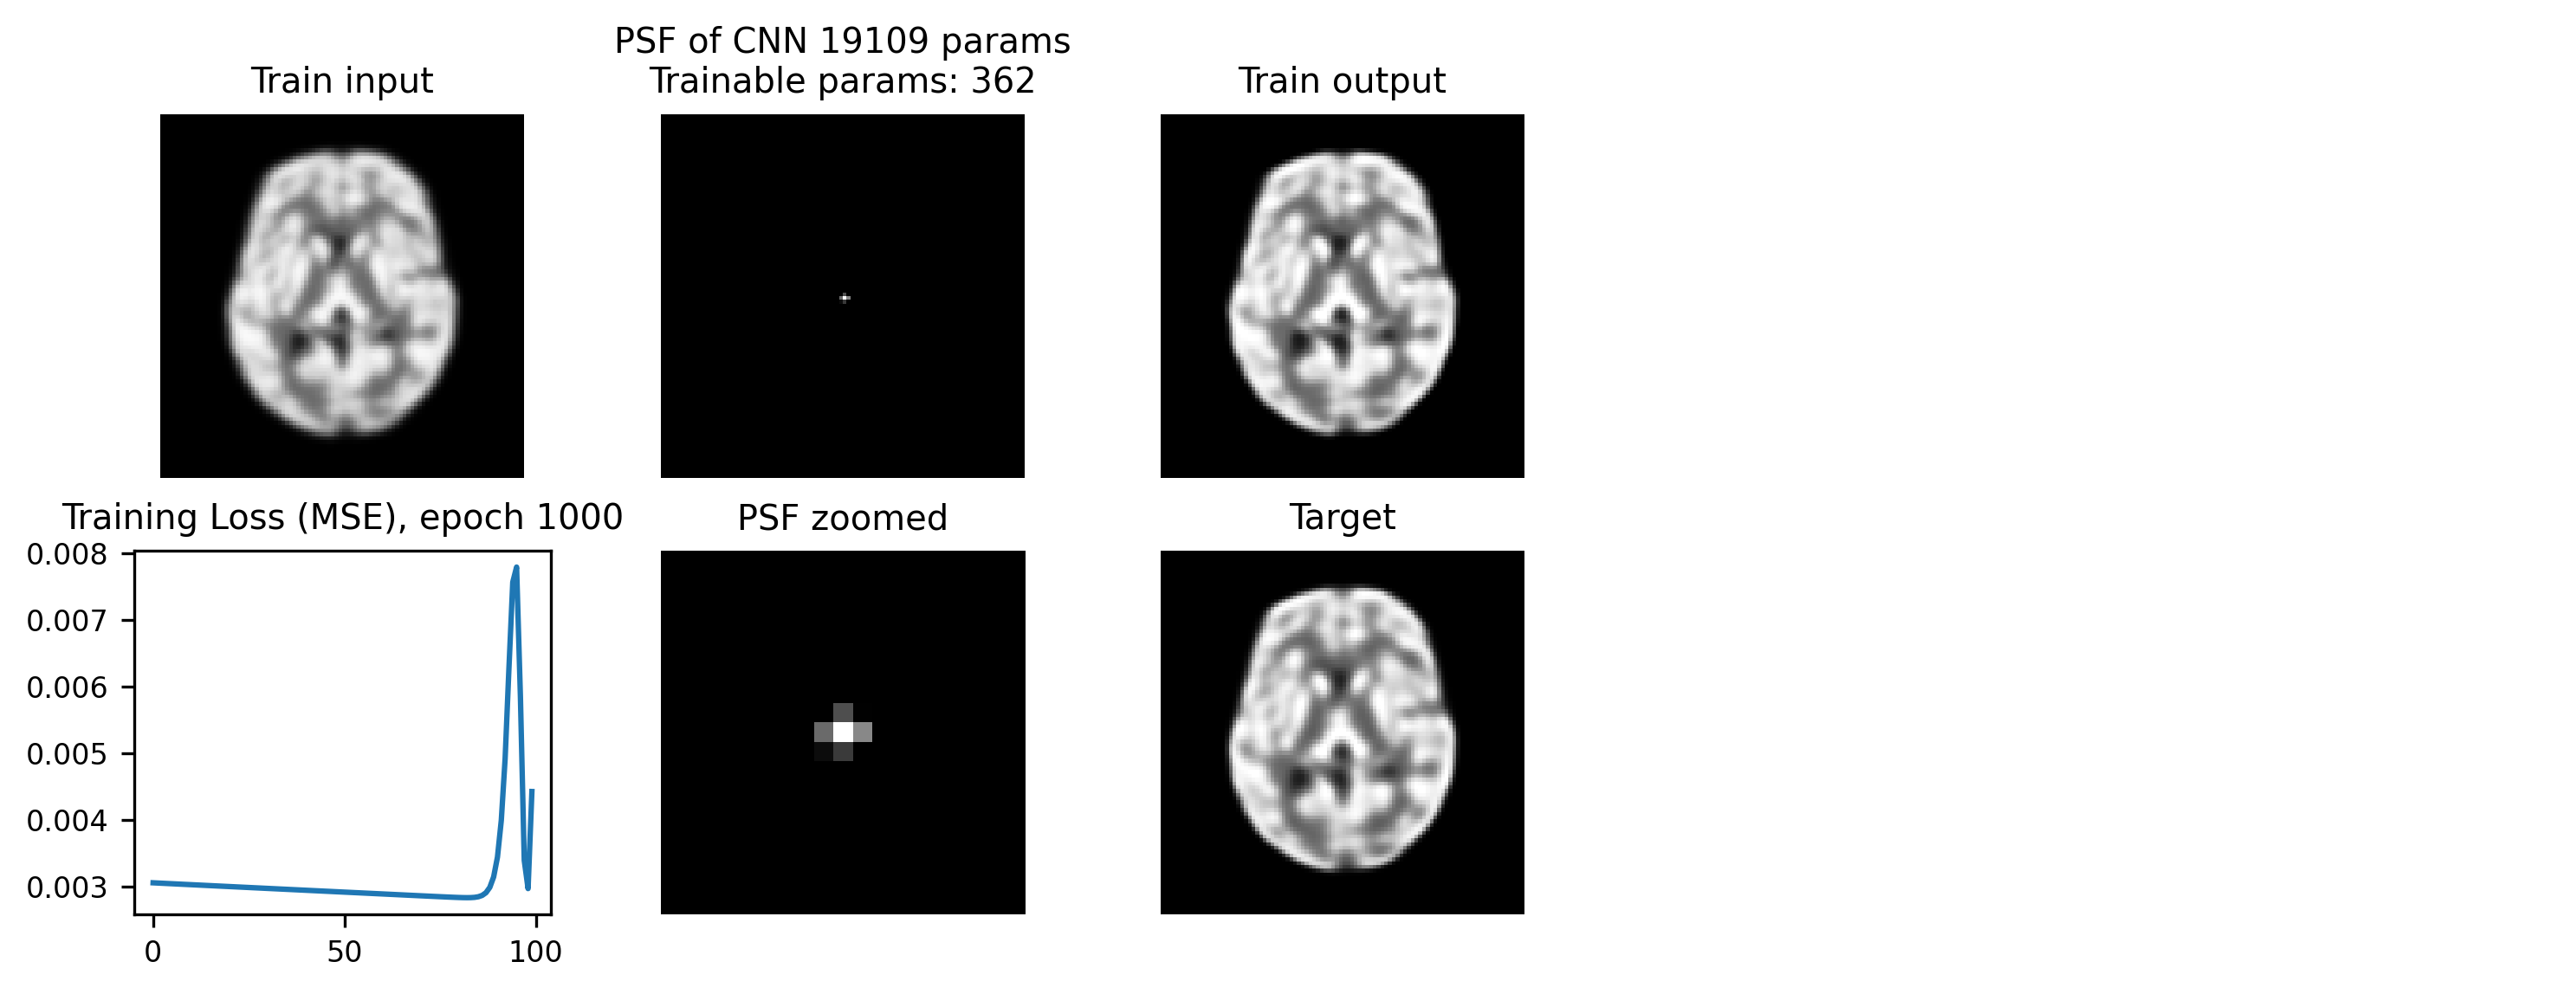

In [10]:
# Now use a CNN for improved performance
# -------------------------------------------------------------------------------------------
# -------------------- SET UP A CLASS FOR A CONFIGURABLE CNN --------------------------------
# -------------------------------------------------------------------------------------------
class CNN_configurable(nn.Module):
    def __init__(self, num_inputs=1, n_hlay=2, n_chan=32, ksize=3):
        super().__init__()

        layers =    [nn.Conv2d(num_inputs, n_chan, ksize, padding=ksize//2), nn.PReLU()]

        for _ in range(n_hlay):
          layers += [nn.Conv2d(n_chan,     n_chan, ksize, padding=ksize//2), nn.PReLU()]

        layers +=   [nn.Conv2d(n_chan,     1,      ksize, padding=ksize//2), nn.PReLU()]

        self.cnn = nn.Sequential(*layers)

    def forward(self, x): return th.squeeze(self.cnn(x.unsqueeze(0)))

trainable_cnn  = CNN_configurable().to(device) # Create a CNN object
model_name     = 'CNN %d params' % (count_parameters(trainable_cnn))

# -------------------------------------------------------------------------------------------
# ----------------- SET UP LOSS FUNCTION, OPTIMISER, AND LIST TO RECORD LOSS ----------------
# -------------------------------------------------------------------------------------------
loss_function = nn.MSELoss()
optimiser     = th.optim.Adam(trainable_cnn.parameters(), lr=1e-3)
train_loss    = list() # Tracking the training of the kernel

# -------------------------------------------------------------------------------------------
# ---------------------------- TRAIN THE CNN ---------------------------------
# -------------------------------------------------------------------------------------------
total_epochs     = 1000
fig, axs = plt.subplots(2,5)

for ep in range(total_epochs+1):
    trainable_cnn.train()  # First ensure the module is in training mode
    optimiser.zero_grad()  # set the gradients to zero
    training_output_th = trainable_cnn(input_image_th)
    loss = loss_function(training_output_th, target_image_th)
    train_loss.append(loss.item())
    output_PSF_th = trainable_cnn(point_input_th)
    loss.backward()    # Find the gradients
    optimiser.step()   # Does the update

    if ep % 50 == 0:
        for a in axs.flat:
            a.cla(); a.axis('off')

        axs[1,0].axis('on')
        axs[1,0].plot(train_loss[-100:]); axs[1,0].set_title(f'Training Loss (MSE), epoch {ep}')

        axs[0,0].imshow(th_2_np(input_image_th),vmax=np.max(true));     axs[0,0].set_title('Train input')
        axs[0,2].imshow(th_2_np(training_output_th),vmax=np.max(true)); axs[0,2].set_title('Train output')
        axs[1,2].imshow(th_2_np(target_image_th),vmax=np.max(true));    axs[1,2].set_title('Target')

        axs[0,1].imshow(th_2_np(output_PSF_th))
        axs[0,1].set_title('PSF of %s\nTrainable params: %d' % (model_name,count_parameters(trainable_kernel)))
        axs[1,1].imshow(th_2_np(output_PSF_th[int(nxd*0.4)+1:int(nxd*0.6)+1,int(nxd*0.4)+1:int(nxd*0.6)+1]))
        axs[1,1].set_title('PSF zoomed')

        clear_output(wait = True); display(fig); plt.pause(0.1)

# Optional extra tasks to consider:
# 1) Change the CNN so that it seeks to match the ground truth
# 2) Change the CNN so that it seeks to convert FBP to MLEM+PSF
# 3) Compare performance of the CNN to the single kernel case
# 4) Experiment with increasing or decreasing the complexity of the CNN (number of trainable parameters)

# AI for image reconstruction
* We can't use the radon and iradon functions for trainable image reconstruciton methods, as radon and iradon use NumPy arrays. Instead we will use radon to precalculate the forward projections of every possible point source, store in a system matrix, then place that into a PyTorch tensor (can then propagate gradients through the projector, and backprojector)

In [11]:
# -------------------------------------------------------------------------------------------
# ----------------- MAKE SYSTEM MATRIX FOR IMAGE RECONSTRUCTION -----------------------------
# -------------------------------------------------------------------------------------------
from joblib import Parallel, delayed # Allow potential parallel processing with multiple cores

def create_radon_transform_matrix_parallel():  # nxd, azi_angles assumed global
    def get_radon(xv, yv):
        point_source        = np.zeros((nxd, nxd))
        point_source[xv,yv] = 1.0
        return radon(point_source, azi_angles, circle=False).flatten()
    coords = [(xv, yv) for xv in range(nxd) for yv in range(nxd)]

    radon_of_points= Parallel(n_jobs=-1)(delayed(get_radon)(xv, yv) for xv,yv in tqdm(coords))
    radon_np = np.array(radon_of_points, dtype=np.float32)
    return th.from_numpy(radon_np).T.contiguous()

#--- LOAD A PRECALCULATED SYSTEM MATRIX OR ELSE CREATE THE SYSTEM MATRIX FROM SCRATCH
def load_or_create_sys_mat(filename):
  try:
    system_matrix = th.load(filename) # Attempt to load the array from the file
    print(f"Loaded system_matrix from {filename} for sinogram size {nrd} x {nphid}")
  except FileNotFoundError:
    print(f"No system matrix file found. Will make system_matrix and save to {filename}")
    system_matrix = create_radon_transform_matrix_parallel()
    th.save(system_matrix, filename)
  return system_matrix

In [12]:
# -------------------------------------------------------------------------------------------
# ------- MAKE SYSTEM MATRIX AND DEFINE FORWARD AND BACK PROJECTION FUNCTIONS ---------------
# -------------------------------------------------------------------------------------------
sys_mat = load_or_create_sys_mat("system_mat_%d_%d.pt" % (nxd,nphid)).to(device)

def fp_system_torch(image, sys_mat, nxd, nrd, nphi):
    return (sys_mat @ image.flatten()).reshape(nrd, nphi)

def bp_system_torch(sino,  sys_mat, nxd, nrd, nphi):
    return (sys_mat.T @ sino.flatten()).reshape(nxd, nxd)

# Optional extra tasks:
# 1) Display the system matrix using imshow
# 2) show 3 example columns of the system matrix using imshow
# 3) show 3 example rows of the system matrix using imshow

Loaded system_matrix from system_mat_96_48.pt for sinogram size 136 x 48


# MLEM as a network
* We will create a "network" which corresponds to a fixed number of MLEM iterations ("unrolled" or "unfolded" iterations)
* Can try with and without trainable parameters
* For the trainable version, for simplicity we will train a CNN to process the image between iterations (can use this CNN to regularise, or accelerate the reconstruction (if we use the ground truth as the target), according to the loss function we choose)


In [13]:
#================================================================
# Now create a recon network class: MLEM
#================================================================
class MLEM_Net(nn.Module):
    def __init__(self, num_iterations, cnn, sino_for_reconstruction):
        super().__init__()
        self.num_iterations = num_iterations
        self.sino_ones      = th.ones_like(sino_for_reconstruction)
        self.sens_image     = bp_system_torch(self.sino_ones, sys_mat, nxd, nrd, nphid)
        self.cnn            = cnn
        self.prelu          = nn.PReLU()
    def forward(self, sino_for_reconstruction):
        recon_image = th.ones(nxd,nxd).to(device)
        for it in range(self.num_iterations):
            fpsino        = fp_system_torch(recon_image, sys_mat, nxd, nrd, nphid)
            ratio_sino    = sino_for_reconstruction / (fpsino + 1e-8)
            bp_ratio_sino = bp_system_torch(ratio_sino, sys_mat, nxd, nrd, nphid)
            recon_image   = recon_image * bp_ratio_sino / (self.sens_image + 1e-8)
            # Inter update regularisation via a CNN
            recon_image   = th.abs(self.cnn(recon_image))
        return recon_image, fpsino, ratio_sino, bp_ratio_sino

# Make a trainable CNN
trainable_cnn       = CNN_configurable(n_hlay=4, n_chan=32).to(device)

number_MLEM_iterations = 2
sinogram_to_use_th  = np_2_th(sinogram).to(device)
# instantiate the MLEM class - to create a reconstruction object
mlemnet = MLEM_Net(number_MLEM_iterations, trainable_cnn, sinogram_to_use_th).to(device)

Text(0.5, 1.0, 'Measured')

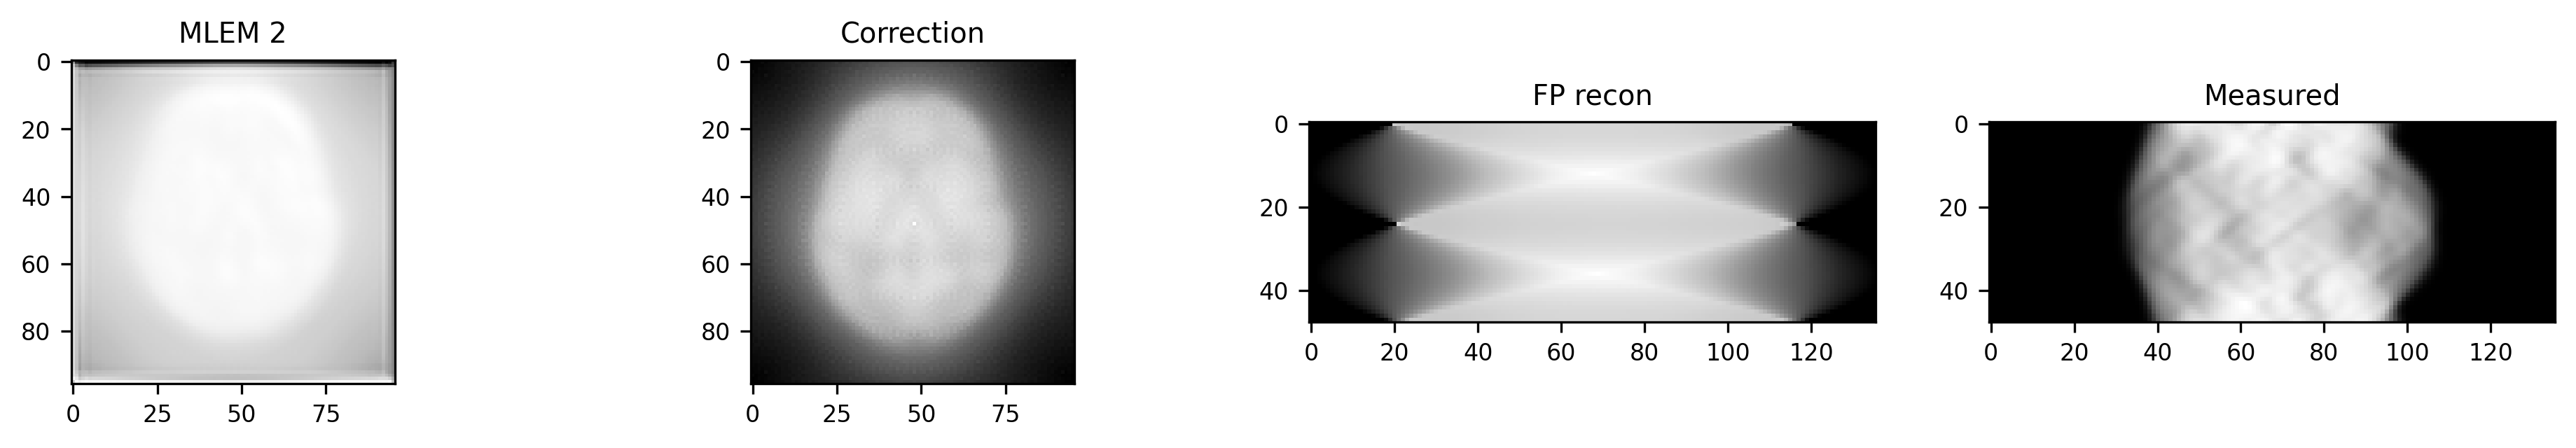

In [14]:
#Try the reconstruction without any training
recon, rec_fp, ratio_sino, bp_ratio_sino = mlemnet(sinogram_to_use_th)
fig2, axs2 = plt.subplots(1,4, figsize=(16,2))
axs2[0].imshow(th_2_np(recon));            axs2[0].set_title('MLEM %d' % (number_MLEM_iterations))
axs2[1].imshow(th_2_np(bp_ratio_sino));    axs2[1].set_title('Correction')
axs2[2].imshow(th_2_np(rec_fp).T);         axs2[2].set_title('FP recon')
axs2[3].imshow(sinogram.T);                axs2[3].set_title('Measured')

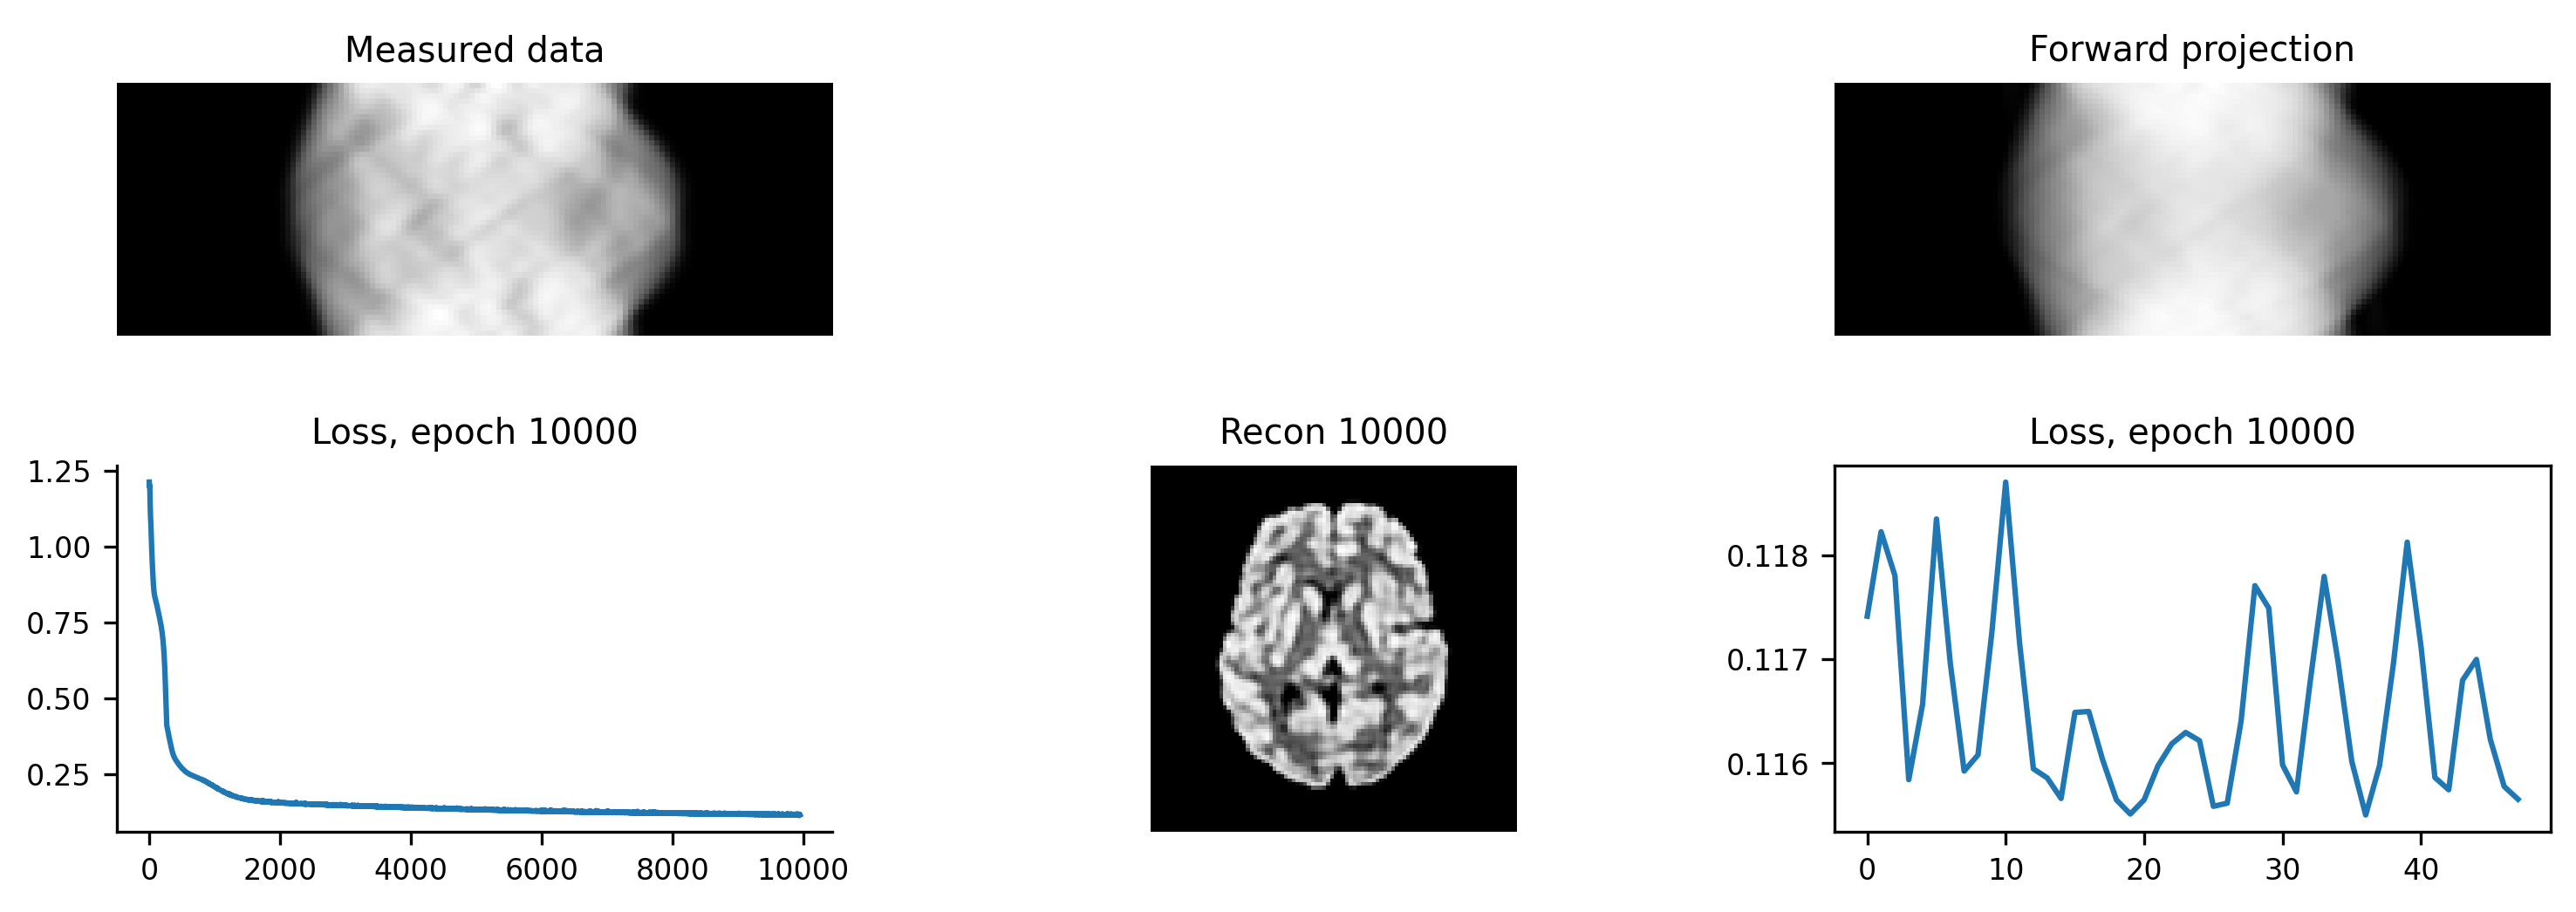

In [15]:
#===============================================TRAIN THE NETWORK
loss_fun  = nn.MSELoss()
optimiser = th.optim.Adam(mlemnet.parameters(), lr=1e-4)

train_loss = list()
# Here we are using the ground truth as the target image!
target_image_th = np_2_th(true.copy()).to(device)

for ep in range(10000+1):
    optimiser.zero_grad() # set the gradients to zero
    recon, rec_fp, ratio_sino, bp_ratio_sino = mlemnet(sinogram_to_use_th)

    # Ground truth supervised
    loss = loss_fun(recon, th.squeeze(target_image_th))

    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update

    if ep % 50 == 0:
        fig2, axs2 = plt.subplots(2,3) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].imshow(th_2_np(sinogram_to_use_th).T); axs2[0,0].set_title('Measured data')
        axs2[0,0].set_axis_off();         axs2[0,1].set_axis_off()
        axs2[0,2].set_axis_off();         axs2[1,1].set_axis_off()
        axs2[1,1].imshow(th_2_np(recon)); axs2[1,1].set_title('Recon %d' % (ep))

        axs2[0,2].imshow(th_2_np(rec_fp).T);        axs2[0,2].set_title('Forward projection')
        axs2[1,2].plot(train_loss[-49:-1]);         axs2[1,2].set_title('Loss, epoch %d' % ep)
        axs2[1,0].plot(train_loss[ 49:-1]);         axs2[1,0].set_title('Loss, epoch %d' % ep)
        axs2[1,0].spines['top'].set_visible(False); axs2[1,0].spines['right'].set_visible(False)
        clear_output(wait=True); plt.pause(0.001)

# Optional extra tasks:
# 1) Conduct a performance comparison with other reconstruction methods
# 2) How might the CNN be integrated into the MLEM algorithm differently?
# 3) What might it look like to have a MAPEM-style update?
# 4) Consider how more training data might be used

# Deep Image Prior
* This method takes any input image, and trains a CNN to convert it to another image, which when forward projected, should match the measured sinogram - hence the output from the CNN is in fact a reconstructed image
* We use a loss function to assess agreement between the forward projection and the sinogram, and train the CNN parameters to minimise that loss function value

In [19]:
#================================================================
# Now create a recon network class: used deep image prior (DIP)
#================================================================
class Z_CNN_Net(nn.Module):
    def __init__(self, cnn, nxd, input_image):
        super().__init__()
        self.z_image    = input_image
        self.cnn        = cnn
    def forward(self):
        recon         = self.cnn(self.z_image)
        fpsino        = fp_system_torch(recon, sys_mat, nxd, nrd, nphid)
        return recon, fpsino

z_image        = th.rand(nxd,nxd).to(device)

trainable_cnn  = CNN_configurable(n_hlay=4, n_chan=nxd).to(device)  # create a new CNN object from the CNN class
znet           = Z_CNN_Net(trainable_cnn, nxd, z_image).to(device)

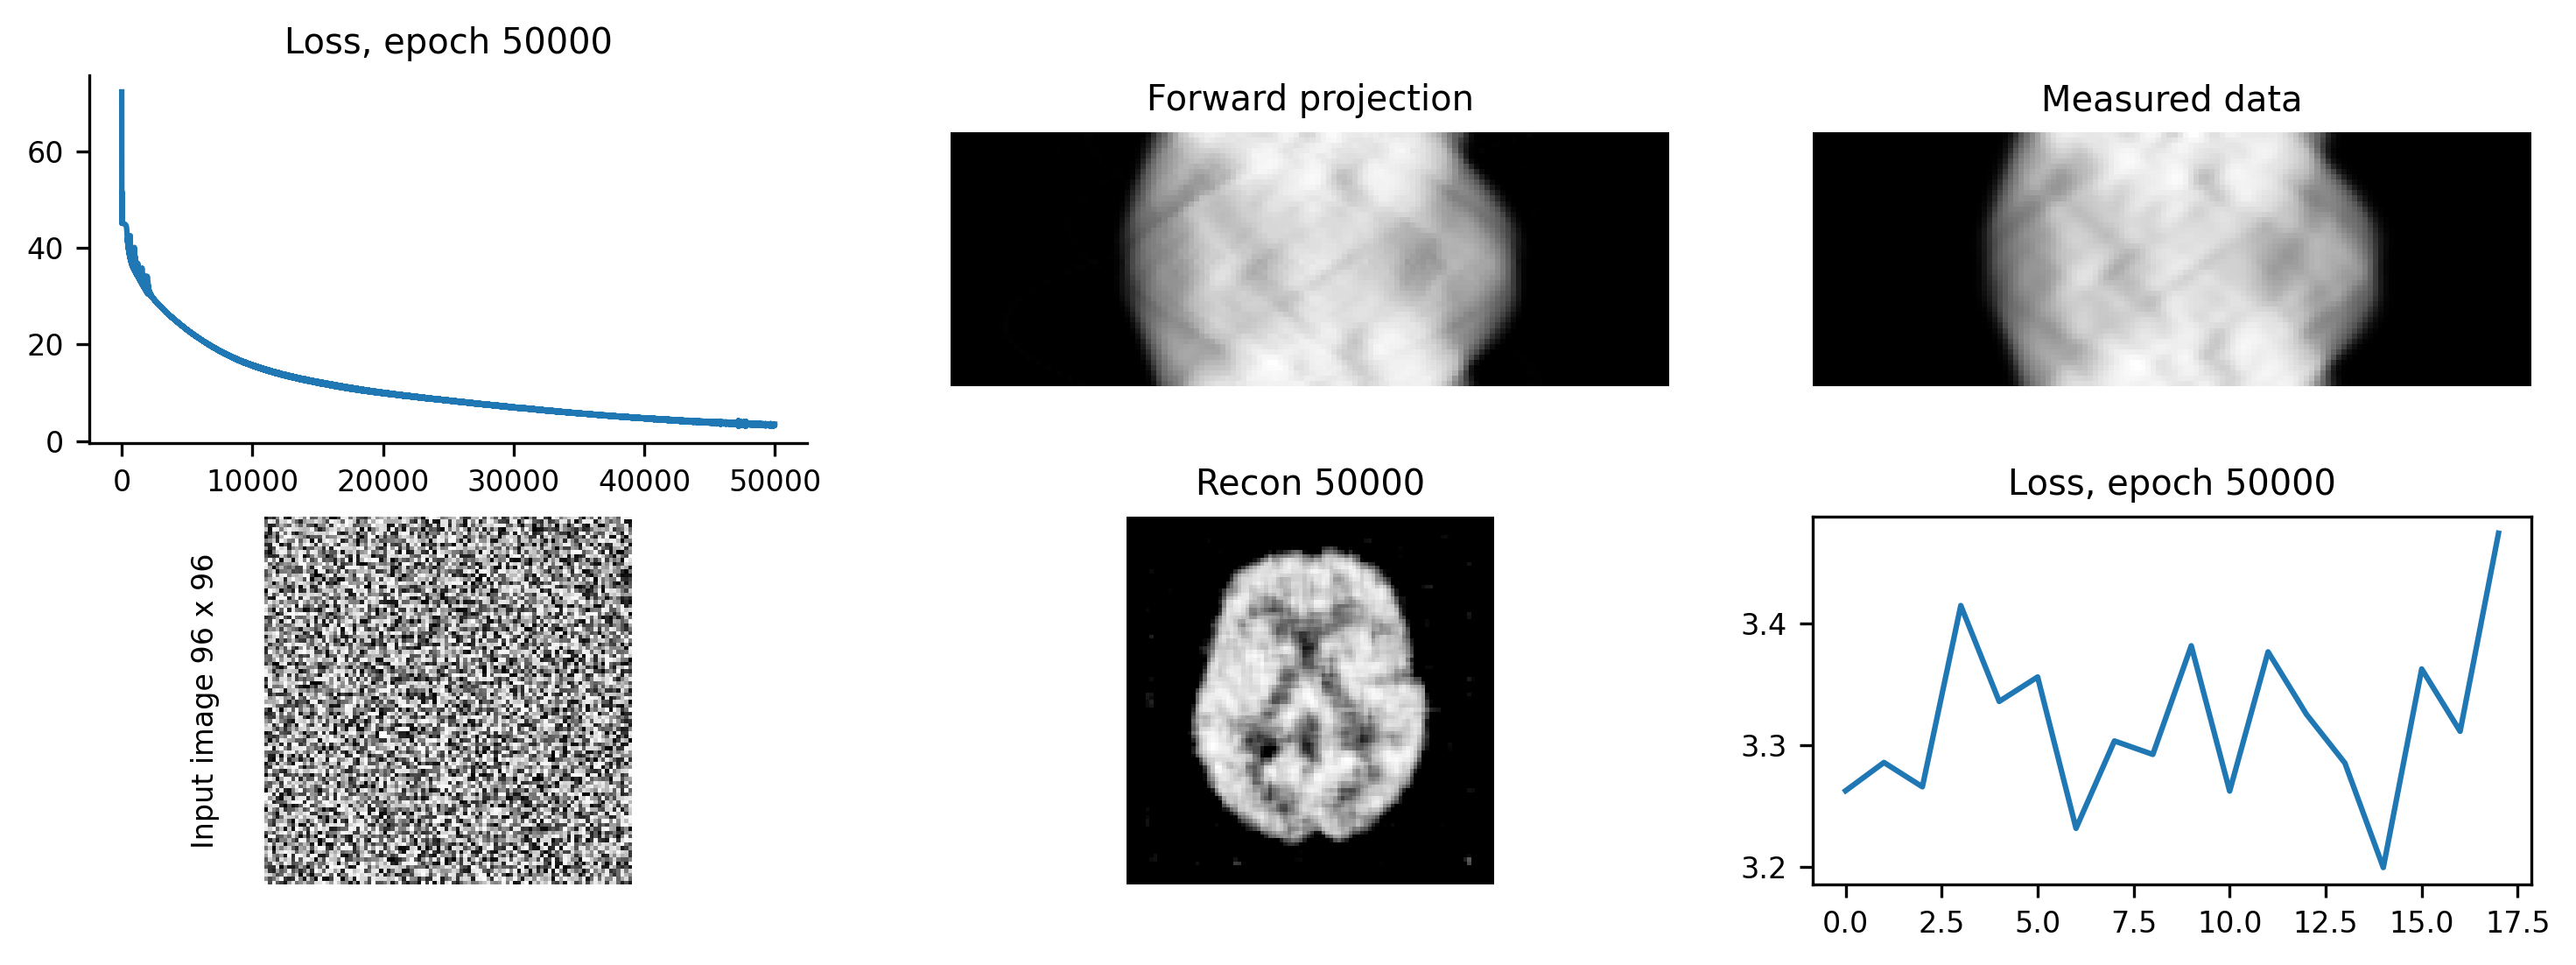

In [20]:
#===============================================TRAIN THE NETWORK
def prmse_th(im, ref):  # % root mean square error for torch tensors
    diff2 = (im - ref)**2
    ref2  = (     ref)**2
    return 100.0 * (th.sqrt( th.sum(diff2) / th.sum(ref2) ))

loss_fun  = prmse_th # Use PRMSE as the loss function

optimiser = th.optim.Adam(znet.parameters(), lr=5e-5)
train_loss = list()

target = th.squeeze(np_2_th(sinogram)).to(device)

for ep in range(50000 +1):
    optimiser.zero_grad() # set the gradients to zero
    recon, rec_fp    = znet()
    loss = loss_fun(rec_fp, target)
    train_loss.append(loss.item())
    loss.backward() # Find the gradients
    optimiser.step() # Does the update

    if ep % 50 == 0:
        fig2, axs2 = plt.subplots(2,3) # No. rows, cols,  figsize Width,Height (inches)
        axs2[0,0].spines['top'].set_visible(False); axs2[0,0].spines['right'].set_visible(False)
        axs2[0,1].set_axis_off();            axs2[0,2].set_axis_off();
        axs2[1,0].set_axis_off();            axs2[1,1].set_axis_off();
        axs2[0,2].imshow(sinogram.T);        axs2[0,2].set_title('Measured data')
        axs2[0,1].imshow(th_2_np(rec_fp).T); axs2[0,1].set_title('Forward projection')
        axs2[1,0].imshow(th_2_np(z_image));  axs2[1,0].set_ylabel('Input image %d x %d' % (nxd,nxd))
        axs2[1,0].text(-0.2, 0.5, 'Input image %d x %d' % (nxd,nxd),
               ha='left', va='center', rotation='vertical', transform=axs2[1,0].transAxes)

        axs2[1,1].imshow(th_2_np(recon));    axs2[1,1].set_title('Recon %d' % (ep))
        axs2[1,2].plot(train_loss[-19:-1]);  axs2[1,2].set_title('Loss, epoch %d' % ep);
        axs2[0,0].plot(train_loss[19:-1]);   axs2[0,0].set_title('Loss, epoch %d' % ep);
        clear_output(wait=True); plt.pause(0.001)

# Optional extra tasks:
# Convergence is slow with the current input image and network, not even complete after 50k epochs!
# Try different inputs to the CNN
# 1) FBP image
# 2) Just a BP image (best to normalise by dividing by a backprojection of uniform sinogram data)
# 3) Question for further thought - how might PSF modelling be introduced?